# **Building a handwritten-digits classifier with several ML algorithms**
`categories: classification tasks, computer vision, neural networks, logistics regression, kNN`

## Introduction

In this project we will analyse a dataset of images representing handwritten digits from 0 to 9, and try several classification algorithms in order to correctly classify them.<br/> 
Given an image, we want our models to be able to say, e.g., "it's a 1" or "it's a 8".<br/>
The following algorithms will be used:
- **logistic regression**
- **k-nearest neighbors (kNN)**
- **multilayer perceptron (deep neural network)**

This project is the first attempt at getting our hands dirty with deep learning and neural networks in general.<br/>
Very briefly, a neural network (nn) is, mathematically, a function composition:

$$y = f_{out}(f_{l}(f_{l-1}(...f_{in}(\textbf{x}))))$$

Where $\textbf{x}$ is the input feature vector, $y$ is the output (can be a number in regression or a probability estimate/class in classification).<br/>
The input and output layer of neurons are represented by $f_{out}$ and $f_{in}$, respectively; the remaining functions represent the inner neuron layers.

In particular, we're interested in the **multilayer perceptron**, a kind of fully-connected feed-forward nn which can be represented as a directed acyclic graph (DAG), like the image below:
<br/>
<br/>

<center>!<img src="imgs/mlp.png" width=550 height=400/><center/>

    Fig.: a multilayer perceptron with one four-neurons hidden layer, represented as a DAG
    
Image source: [here](https://becominghuman.ai/multi-layer-perceptron-mlp-models-on-real-world-banking-data-f6dd3d7e998f).

Another kind of feed-forward nn's are convolutional neural networks, which reach state-of-the-art performances on images classification.<br/> 
Other neural networks architectures are however possible, which are not DAGs; an example are recurrent neural networks.

## Project's goals

The essential goal is to practice with neural networks; in particular playing with their hyperparameters to start having an idea of how hard is to tune them.<br/>
We also want to compare nn's performances with simpler (at least in terms of explainability) algorithms: are neural networks really worth the trouble for this particular dataset?

### Strategy

Because we're going to use a small dataset (1797 instances), we're going to split it into a train and a test set, perform **cross-validation** on the train set and use the test just to assess the best model's performance (see par. 5.7.1 of *The hundred-page machine learning book*, for example).<br/>
As a metric we choose **accuracy**, because all digits are considered equally important so we're not going to use more specific metrics like AUC, precision or recall.

*Note that "test set" is referred to two different sets in the context of cross-validation (equivalent to validation set) and in the context of model assessment.*

### Summary of results
Logistic regression performs acceptably well on unseen data (94.8%).<br/>
kNN and neural networks yield the best accuracy, which is virtually the same for both (97.8%).<br/>
One hidden layer is enough for the multilayer perceptron to reach its best performance.

## Modules and libraries

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# dataset
from sklearn.datasets import load_digits

# ML functionalities
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate  #(*)
from sklearn.metrics import accuracy_score

# random state for reproducibility
rs = 1

#(*) note: cross_validate is much more flexible than cross_val_score

## Dataset loading and exploration

Our dataset is a collection of 1797 grayscale images, each representing a handwritten digit. The resolution of each image is 8 by 8, i.e. 64 pixels.<br/>
More information on the dataset can be found at [the UCI repository](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits). We will access the data trough the `sklearn.datasets.load_digits` function.

Let's load the data in a dataframe and take a look at them:

In [2]:
data = load_digits(as_frame=True)

imgs = data.data  # images
target = data.target  # target values (i.e. digit label: 0, 1, 2,...)

In [3]:
print('(n_imgs, n_features) =', imgs.shape, '\n')
imgs.head()

(n_imgs, n_features) = (1797, 64) 



,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_6,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


As we see, each column represent the value of a particular pixel. For example, `pixel_0_7` represents the value of the last pixel in the first row of each image.<br/>
From the docs, we read that each pixel has a value in the range 0-16. Let's see if the data types are consistent.

In [4]:
imgs.dtypes.unique()

array([dtype('float64')], dtype=object)

Each column is a float, so that's fine.<br/> 
Let's check if the range of each column is actually 0-16, as declared (i.e. no outliers):

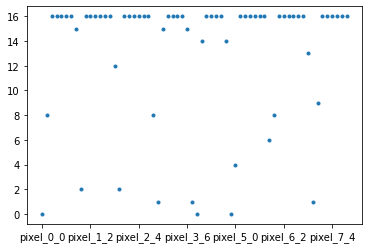

In [5]:
imgs.max().plot(style='.')
plt.show()

Some pixels' values are always less than 16, but that's reasonable (see the image plot below). However, no outliers are present.

Are there missing values?

In [6]:
# total missing values in the dataset
imgs.isnull().sum().sum()

0

We can now consider the `target` column. Let's sneak a peek: 

In [7]:
target.head(10)

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
Name: target, dtype: int64

It's made of integers, as expected. Any missing value or outlier?

In [8]:
# missing values
target.isnull().sum()

0

In [9]:
# spotting outliers
target.describe()

count    1797.000000
mean        4.490818
std         2.865304
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: target, dtype: float64

There are no outliers. The previous cell suggests another question: **is the dataset balanced?** In other words, are the digits more or less equally represented?

In [10]:
target.value_counts().sort_index()

0    178
1    182
2    177
3    183
4    181
5    182
6    181
7    179
8    174
9    180
Name: target, dtype: int64

Within 4%, the dataset is balanced. 

If we look back at the `target` column preview, the digits seem to have a progressive order:

In [251]:
target.head(20)

0     0
1     1
2     2
3     3
4     4
5     5
6     6
7     7
8     8
9     9
10    0
11    1
12    2
13    3
14    4
15    5
16    6
17    7
18    8
19    9
Name: target, dtype: int64

We can explore this potential issue with a quick plot:

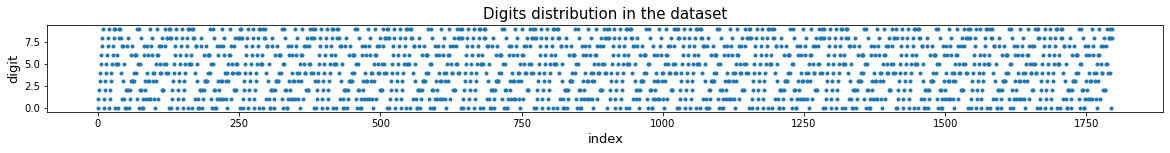

In [12]:
target.plot(style='.', figsize=(20, 1.6))
plt.title('Digits distribution in the dataset', fontsize=15)
plt.xlabel('index', fontsize=13)
plt.ylabel('digit', fontsize=13)
plt.show()

What we have found is interesting: there's definitely a *repetitive pattern* in how the digits are distributed inside the dataset.<br/>
This could (maybe) lead the models astray, so we're going to **shuffle the data** when we create train and test sets, in order to break this pattern.

As a final step in data exploration, let's visualize some of the images in the dataset:

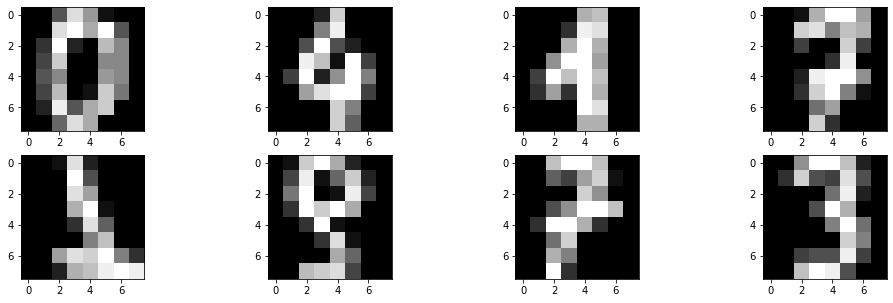

In [13]:
# select eight images from the dataset
sample = imgs.iloc[[0, 100, 200, 300, 1000, 1100, 1200, 1300], :]
sample.reset_index(inplace=True, drop=True)

# plot them
fig, axs = plt.subplots(2, 4, figsize=(17, 5))

for i, ax in enumerate(axs.flat):
    img = sample.iloc[i, :].values.reshape(8, 8)
    ax.imshow(img, cmap='gray')   

The images have very low resolution. The advantage of using such a toy dataset is that training time is greatly reduced.

## Train and test dataset

Now we create the train and test dataset with a 85/15 proportion.

In [70]:
# concatenate features and labels
imgs_target = pd.concat([imgs, target], axis=1)
# shuffle the dataset
imgs_target = imgs_target.sample(frac=1, random_state=rs)
# group by digit label followed by sampling, in order to obtain balanced train and test sets
train_data = imgs_target.groupby('target').apply(lambda x: x.sample(frac=0.85, random_state=rs))
# shuffle to break any already existing or created pattern
train_data = train_data.droplevel('target').sample(frac=1, random_state=rs)
test_data = imgs_target.loc[~imgs_target.index.isin(train_data.index)]
train_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

X_train, y_train = train_data.iloc[:, :-1], train_data.target
X_test, y_test = test_data.iloc[:, :-1], test_data.target

The observed distribution pattern (see previous paragraph) should be absent.

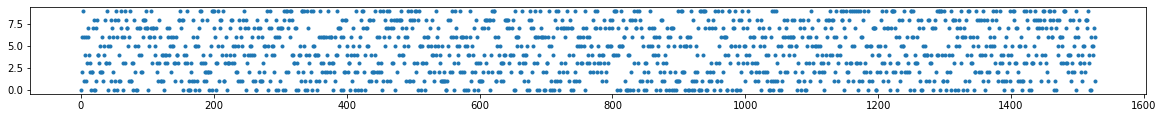

In [71]:
y_train.plot(style='.', figsize=(20, 1.6))
plt.show()

## Logistic regression

Logistic regression is a generalization of linear regression where a linear combination of the features is used in order to predict the probability that a certain example in the dataset belongs to a certain class. It's the simplest model we will try and will be useful to answer to the question: are neural networks really necessary for this dataset?

[**note**: the logistic regression can be seen as a neural network with no hidden layers and a sigmoid as activation function. See the introduction to nn's in Stanford's course CS229]

Let's train the model on the train set and assess the performance on the test set.

In [72]:
lr = LogisticRegression(max_iter=700, solver='newton-cg')
lr.fit(X_train, y_train)

pred_train = lr.predict(X_train)
pred_test = lr.predict(X_test)

print('Accuracies:')
print('train set:', accuracy_score(y_train, pred_train))
print('test set:', round(accuracy_score(y_test, pred_test), 3))

Accuracies:
train set: 1.0
test set: 0.948


The accuracy on the test set is already 94.8%, while on the train set the model correctly classifies all images. These performance might be the result of a toy dataset being used. It would be interesting to see if these results would be possible on a real-world dataset.

## K-nearest neighbors algorithm

Let's define a function which performs a cross validation on the train set using the scikit-learn implementation of knn.

In [74]:
def knn_cross_validate(
        X: pd.DataFrame, y: pd.Series, nn=5, 
        n_folds=5) -> float:
    """
    Perform cross-validation using k-nearest neighbors algorithm, 
    X as feature set and y as target values (classes).
    
    Return the average accuracy on both train and test ([0, 1]).
    """
    
    knn = KNeighborsClassifier(n_neighbors=nn)
    cross_val_results = cross_validate(knn, X, y, scoring='accuracy', 
                                       cv=n_folds, return_train_score=True)
        
    train_acc = np.average(cross_val_results['train_score'])
    test_acc = np.average(cross_val_results['test_score'])
    
    return round(train_acc, 3), round(test_acc, 3)

In the next cell we will cross-validate the model and plot the mean accuracy on both train and test dataset. We'll use a range of nearest neighbors from 1 to 30, and a 5-folds splitting of the train set.

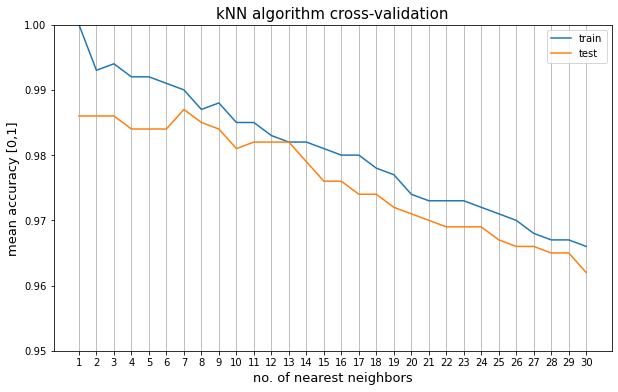

In [109]:
neighbors = list(range(1, 31))

# cross-validate the model
accuracies = [knn_cross_validate(X_train, y_train, nn, n_folds=5) for nn in neighbors]
train_acc = [x[0] for x in accuracies]
test_acc = [x[1] for x in accuracies]

# plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(neighbors, train_acc, label='train')
ax.plot(neighbors, test_acc, label='test')
ax.legend()
ax.set_xticks(neighbors)
ax.set_xticklabels([str(n) for n in neighbors])
ax.set_xlabel('no. of nearest neighbors', fontsize=13)
ax.set_ylabel('mean accuracy [0,1]', fontsize=13)
ax.set_title('kNN algorithm cross-validation', fontsize=15)
ax.grid(axis='x')
ax.set_ylim(0.95, 1)

plt.show()


The model shows better accuracy when using few nearest neighbors, while the performances slowly decrease for larger values.<br/>
Because the mean accuracy is virtually the same for k from 1 to 13 (around 98.5%), and because for k close to 1 the model shows potential signs of overfitting, we will choose as **the best model** the one with the smallest k where the two curves are the closest, i.e. **k=7**. 

We now assess the model performances on the test set.

In [112]:
knn = KNeighborsClassifier(7)
knn.fit(X_train, y_train)

pred_train = knn.predict(X_train)
pred_test = knn.predict(X_test)

print('Best model assessment:')
print('train set accuracy:', round(accuracy_score(y_train, pred_train), 3))
print('test set accuracy:', round(accuracy_score(y_test, pred_test), 3))

Best model assessment:
train set accuracy: 0.99
test set accuracy: 0.978


We have improved the accuracy from 94.8% with logistic regression to 97.8% using knn.<br/>
We underline, however, that the algorithm is very expensive computationally, because it uses all the training data to make each single prediction. For the same reason, it can require high memory usage.

## Multilayer perceptron


We will try lots of different neural network architectures in our search for the best-performing model. Therefore we write some functions to make the iterative process easier and not redundant.

In [114]:
def perceptron_cross_validate(
        X: pd.DataFrame, y: pd.Series, hidden_layer_sizes: tuple, 
        activation='relu', max_iter=1500, n_folds=5, 
        random_state=1) -> (float, float):
    """
    Train a multilayer perceptron with inner architecture defined by 
    hidden_layer_sizes and cross-validate it using n_folds split of data.
    Return the mean accuracy on both train and test sets.
    
    [Note: here `test set` actually means one of the n_folds folds used 
     for cross-validation; not to be confused with the test set for model 
     performance final assessment.]
    """
    
    mlp = MLPClassifier(hidden_layer_sizes, activation=activation, 
                        random_state=random_state, max_iter=max_iter)
    cross_val_results = cross_validate(mlp, X, y, scoring='accuracy', 
                                       cv=n_folds, return_train_score=True)
    train_acc = np.average(cross_val_results['train_score'])
    test_acc = np.average(cross_val_results['test_score'])
    
    return round(train_acc, 3), round(test_acc, 3)


def cross_validate_all(
        X: pd.DataFrame, y: pd.Series, hidden_layers: list, 
        activation='relu', max_iter=1500, n_folds=5, 
        print_progress=True) -> pd.DataFrame:
    """
    Perform the big task: cross-validate the neural network for a set of 
    architectures defined by the hidden_layers list.
    For example, for hidden_layers = [(10, 10), (30, 30), (50, 50)], 
    cross-validate three multilayer perceptrons, each with two equal hidden
    layers with 10, 30 and 50 neurons respectively.
    
    At high level, it's a wrapper for the perceptron_cross_validate function,
    which is called on each element of hidden_layers.
    
    Return a dataframe with the mean accuracies 
    on both the train and test set.
    """
    
    train_accuracies = []
    test_accuracies = []
    
    # cross-validate for all the architectures defined in 
    # the hidden_layers list
    for architecture in hidden_layers:
        train_acc, test_acc = perceptron_cross_validate(X, y, architecture, 
                                                        activation, max_iter, 
                                                        n_folds)
        if print_progress:
            # let the user know which network has been processed
            print(f'{architecture} neurons network: done.')  
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # build a dataframe with results of cross-validation
    results = pd.DataFrame(zip(train_accuracies, test_accuracies), 
                           index=hidden_layers, columns=['train', 'test'])
    
    return results

In [276]:
def plot_results(
        results, x_label, y_label, title, 
        y_lims=(.87, 1.), figsize=(8, 6)):
    """
    Plot results as a vertical bar plot.
    """
    
    fig, ax = plt.subplots(figsize=figsize)

    results.plot(kind='bar', ax=ax)
    
    # adjusting aesthetic
    ax.set_ylim(y_lims[0], y_lims[1])
    ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=0, fontsize=13)
    ax.set_xlabel(x_label, fontsize=14)
    ax.set_ylabel(y_label, fontsize=14)
    ax.set_title(title, fontsize=15)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.grid(axis='y')

    plt.tight_layout()
    plt.show()
    
    return None

### One hidden layer

Let's start with the simplest case, just one layer of neurons between the input and the output layer, and try different number of neurons in exponential order.

In [123]:
# list defining number of neurons in the hidden layer
architectures = [(2 ** n, ) for n in range(1, 10)]

results_df = cross_validate_all(X_train, y_train, architectures)
print()
results_df

(2,) neurons network: done.
(4,) neurons network: done.
(8,) neurons network: done.
(16,) neurons network: done.
(32,) neurons network: done.
(64,) neurons network: done.
(128,) neurons network: done.
(256,) neurons network: done.
(512,) neurons network: done.



,train,test
"(2,)",0.311,0.296
"(4,)",0.888,0.827
"(8,)",0.999,0.940
"(16,)",1.000,0.961
"(32,)",1.000,0.964
"(64,)",1.000,0.967
"(128,)",1.000,0.972
"(256,)",1.000,0.978
"(512,)",1.000,0.974


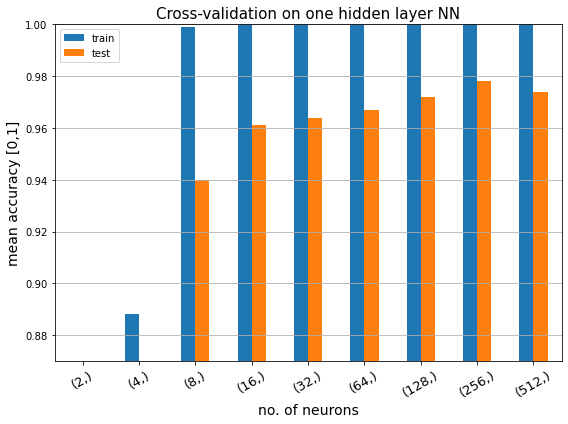

In [267]:
plot_results(results_df, 'no. of neurons', 
             'mean accuracy [0,1]', 
             'Cross-validation on one hidden layer NN')

We see that using 2 or 4 neurons yields an accuracy well below 90%, even on the train set. The accuracy increases to over 90% using 8 or more neurons. The best models are the ones with 128, 256 and 512 neurons, each showing comparable accuracy **between 97 and 98%**.

Let's see if we obtain better performances by moving around those values.

#### **Fine-tuning around 128, 256 and 512 neurons**

In [127]:
ft_around_128 = cross_validate_all(X_train, y_train, 
                                   list(range(90, 160, 10)), 
                                   print_progress=False)
ft_around_128

,train,test
90,1.0,0.971
100,1.0,0.969
110,1.0,0.978
120,1.0,0.978
130,1.0,0.978
140,1.0,0.979
150,1.0,0.975


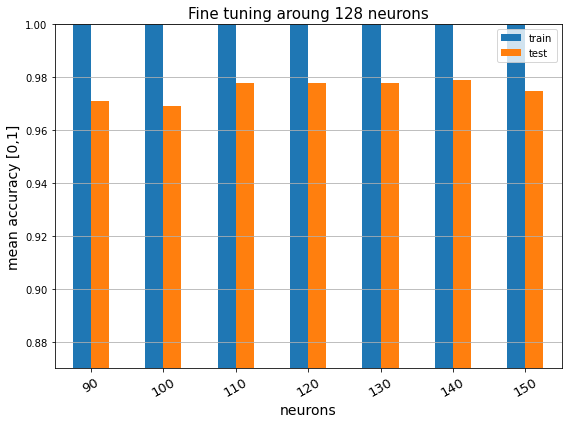

In [268]:
plot_results(ft_around_128, 'neurons', 'mean accuracy [0,1]', 
             'Fine tuning aroung 128 neurons')

The fine tuning in this "region" confirms the previous results: an accuracy between 97 and 98%.<br/>
Let's move to the next set of neurons.

In [131]:
ft_around_256 = cross_validate_all(X_train, y_train, 
                                   list(range(220, 290, 10)), 
                                   print_progress=False)
ft_around_256

,train,test
220,1.0,0.980
230,1.0,0.977
240,1.0,0.974
250,1.0,0.979
260,1.0,0.982
270,1.0,0.978
280,1.0,0.977


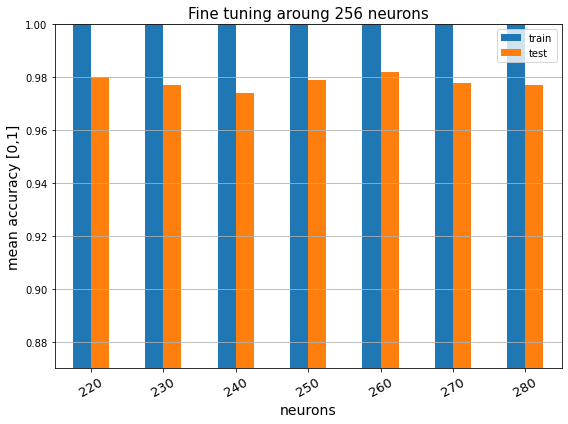

In [270]:
plot_results(ft_around_256, 'neurons', 'mean accuracy [0,1]', 
             'Fine tuning aroung 256 neurons')

The best model here uses 260 neurons, but the improvement is only marginal: 98.2% (probably still in the random variation due to the dataset).

In [136]:
ft_around_512 = cross_validate_all(X_train, y_train, 
                                   list(range(480, 550, 10)), 
                                   print_progress=False)
ft_around_512

,train,test
480,1.0,0.980
490,1.0,0.980
500,1.0,0.983
510,1.0,0.978
520,1.0,0.978
530,1.0,0.982
540,1.0,0.981


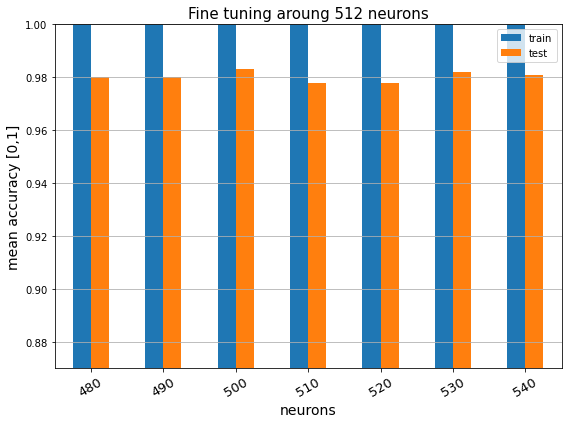

In [271]:
plot_results(ft_around_512, 'neurons', 'mean accuracy [0,1]', 
             'Fine tuning aroung 512 neurons')

Again, no real news come from this fine tuning "region". The best performance is obtained with 500 neurons (98.3%).

We will call the best model the simplest (i.e. fewest neurons) which gave an accuracy over 98%: **260 neurons**.<br/>
The next cell train it on the whole train set and assess its performance on the test set.

In [226]:
mlp_one_final = MLPClassifier(hidden_layer_sizes=(260, ), activation='relu', 
                              max_iter=1500, random_state=rs)

mlp_one_final.fit(X_train, y_train)

train_pred = mlp_one_final.predict(X_train)
test_pred = mlp_one_final.predict(X_test)

print('Best model assessment:')
print('train set:', accuracy_score(y_train, train_pred))
print('test set:', round(accuracy_score(y_test, test_pred), 3))

Best model assessment:
train set: 1.0
test set: 0.978


The best model accuracy on the test set is **97.8%**.

Let's now add more layers to see if the accuracy significantly improves.

### Two hidden layers

Let's repeat essentially the same steps for a nn with two inner layers, varying the number of neurons.

In [151]:
architectures_two = [(8, 8), (16, 16), (32, 32), (64, 64), 
                     (128, 128), (256, 256), (512, 512)]

results_two = cross_validate_all(X_train, y_train, architectures_two)
results_two

(8, 8) neurons network: done.
(16, 16) neurons network: done.
(32, 32) neurons network: done.
(64, 64) neurons network: done.
(128, 128) neurons network: done.
(256, 256) neurons network: done.
(512, 512) neurons network: done.


,train,test
"(8, 8)",0.999,0.927
"(16, 16)",1.000,0.954
"(32, 32)",1.000,0.969
"(64, 64)",1.000,0.972
"(128, 128)",1.000,0.977
"(256, 256)",1.000,0.984
"(512, 512)",1.000,0.984


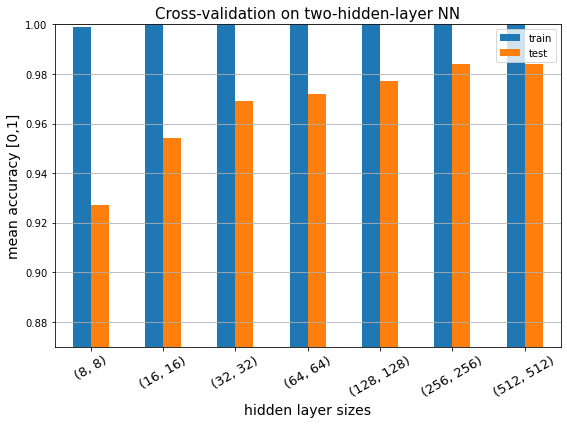

In [272]:
plot_results(results_two, 'hidden layer sizes', 'mean accuracy [0,1]', 
             'Cross-validation on two-hidden-layer NN')

No real improvement is observed since the accuracy is very close to 98%.<br/>
Let's explore the most promising region of hyperparameters, to see if we missed some "sweet spot".

#### **Fine tuning from (220, 220) to (540, 540)**

In [154]:
ft_two = cross_validate_all(X_train, y_train, 
                            [(n, n) for n in range(220, 550, 10)], 
                            print_progress=False)

The best performing nets in this "region" are:

In [223]:
ft_two.loc[ft_two.test == ft_two.test.max()]

,train,test
"(370, 370)",1.0,0.985
"(430, 430)",1.0,0.985


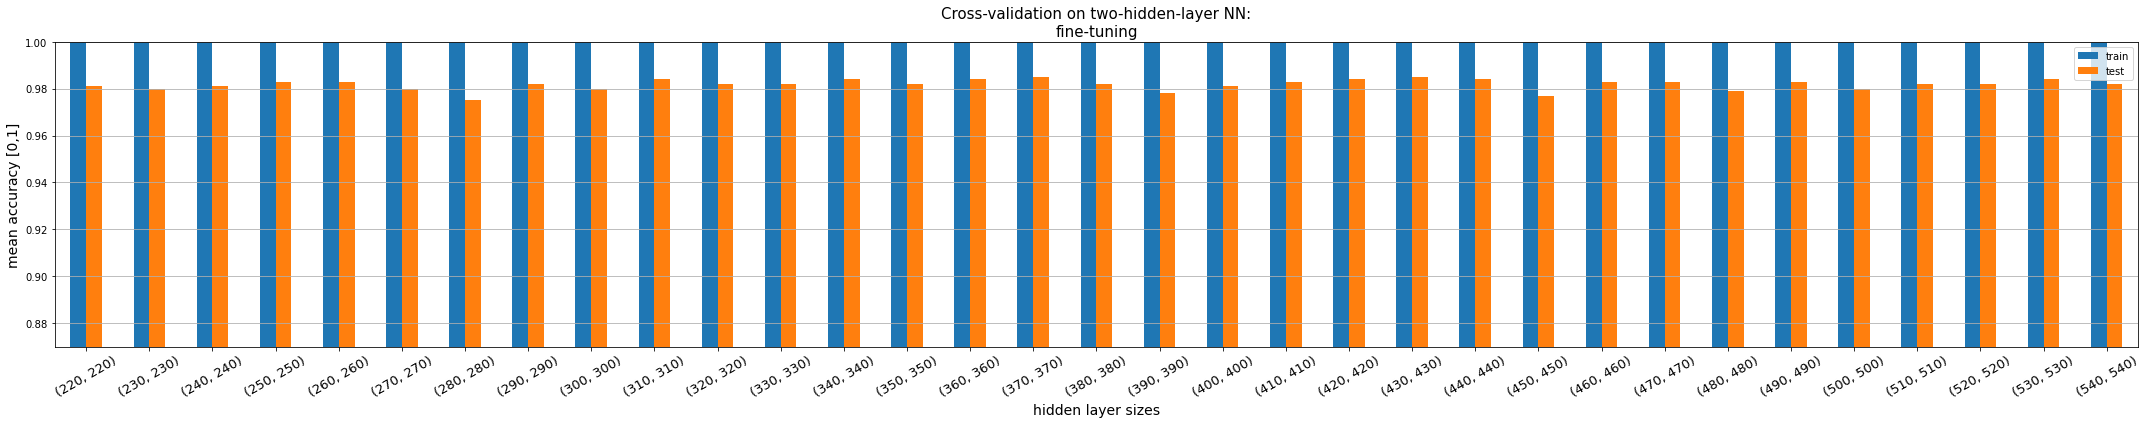

In [273]:
plot_results(ft_two, 'hidden layer sizes', 'mean accuracy [0,1]', 
             'Cross-validation on two-hidden-layer NN:\nfine-tuning',
             figsize=(30, 6))

The performances are very consistent across the range we've explored.<br/>
There's probably no real difference between the one hidden layer and the two hidden layer best accuracies. Of course, we cannot say for sure just by eyeballing the barplots: **we'd need a statistical test to decide whether these architectures really differ in performances**. Anyway, the accuracy is always around 98%, more or less 0.5%, which gives us some real hint that we're not improving the performance by using a more complicated architecture.

Given the above (partial) results, by Occam's razor, the best net to date is the one-hidden-layer.

Let's now add another hidden layer.

### Three hidden layers

In [178]:
architectures_three = [(32, 32, 32),
                       (64,64,64),
                       (128,128,128), 
                       (256, 256, 256),
                       (512, 512, 512)]

results_three = cross_validate_all(X_train, y_train, architectures_three)

(32, 32, 32) neurons network: done.
(64, 64, 64) neurons network: done.
(128, 128, 128) neurons network: done.
(256, 256, 256) neurons network: done.
(512, 512, 512) neurons network: done.


In [239]:
results_three

,train,test
"(32, 32, 32)",1.0,0.959
"(64, 64, 64)",1.0,0.974
"(128, 128, 128)",1.0,0.979
"(256, 256, 256)",1.0,0.984
"(512, 512, 512)",1.0,0.985


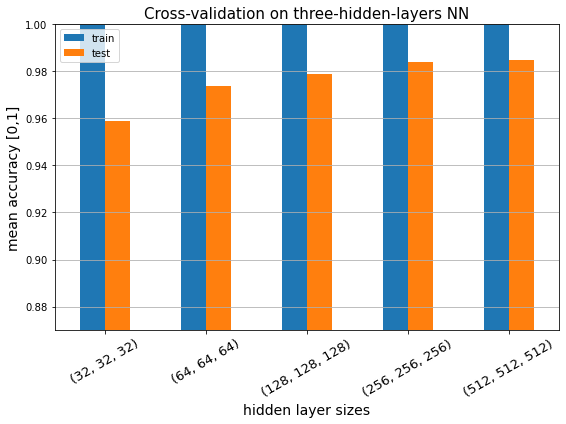

In [274]:
plot_results(results_three, 'hidden layer sizes', 'mean accuracy [0,1]', 
             'Cross-validation on three-hidden-layers NN')

Again, no real improvement seems to appear. 

#### **Fine-tuning from (220, 220, 220) to (540, 540, 540)**

In [183]:
ft_three = cross_validate_all(X_train, y_train, 
                              [(n, n, n) for n in range(220, 550, 10)], 
                              print_progress=False)

The best accuracy is obtained for:

In [218]:
ft_three.loc[[ft_three.test.idxmax()]]

,train,test
"(220, 220, 220)",1.0,0.984


Still around 98%. Are there other networks yielding the same results?

In [219]:
ft_three.loc[ft_three.test == .984]

,train,test
"(220, 220, 220)",1.0,0.984
"(460, 460, 460)",1.0,0.984
"(470, 470, 470)",1.0,0.984
"(500, 500, 500)",1.0,0.984


There's no one single three-hidden-layer net which stands out. This is even clearer by looking at the bar plot:

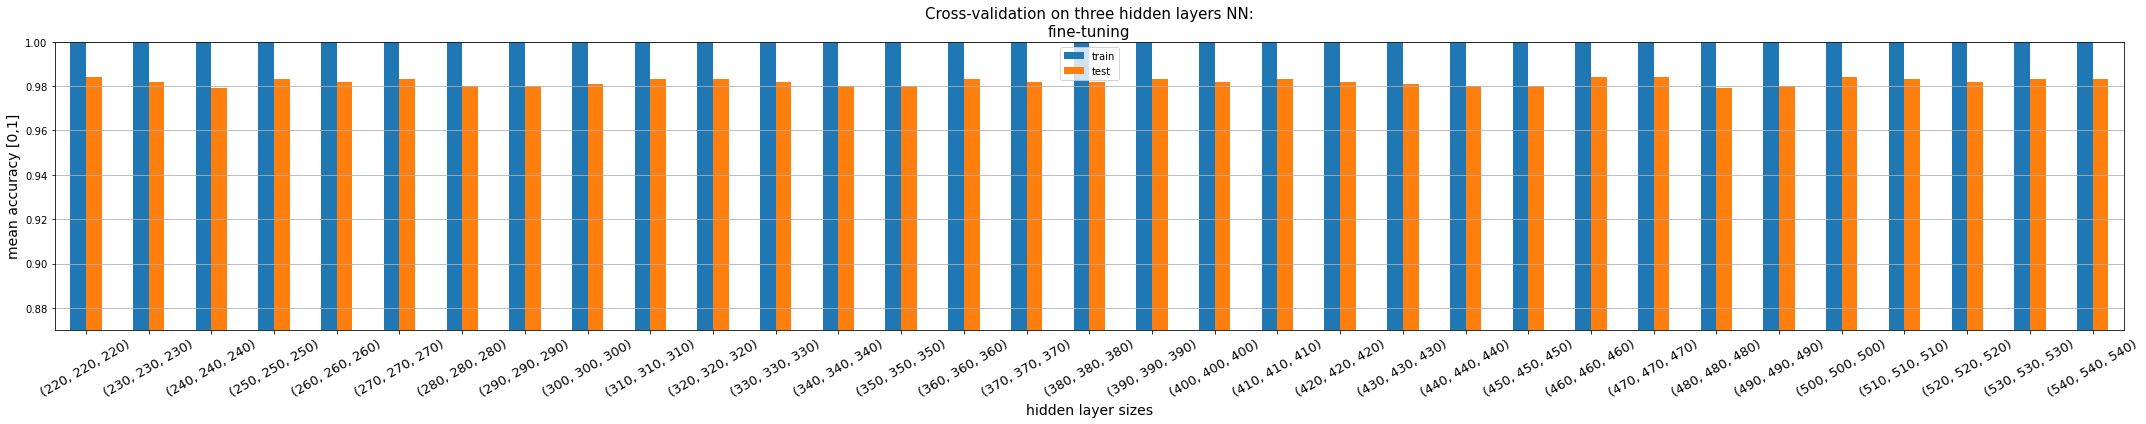

In [275]:
plot_results(ft_three, 'hidden layer sizes', 'mean accuracy [0,1]', 
             'Cross-validation on three hidden layers NN:\nfine-tuning',
             figsize=(30, 6))

The same conclusion of the two-hidden-layers case applies here: the increase in complexity is not justified, given that the accuracy remain around 98%.

## Conclusions

In this project we have tried three different algorithms in order to build a handwritten-digits classifier.<br/>
The accuracies obtained on the **test set** are:

- **logistic regression**: 94.8%
- **K-nearest neighbors**: 97.8%
- **One-hidden-layer perceptron (260 neurons)**: 97.8%
- **Two and three-hidden-layer perceptron**: around 98%

The *logistic regression* was expected to perform worse than the other models, because it is not designed to work with non-linear relationship between input and output. Still, it reaches a quite high accuracy (which potentially may be an artifact of the toy dataset we've used).

*KNN* performs as well as the *multilayer perceptron*. Therefore, we could say that **the use of a multilayer perceptron is not justified with this dataset**, especially if explainability is at stake. We must however consider that KNN is computationally expensive and may not be the right choice when using very large datasets.

Using a perceptron with just one hidden layer of a few hundreds neurons seems to be enough for this task, if we decide to use nn's.

As **next steps** we might consider:
- using a larger dataset with more detailed images (i.e. higher resolution) to see if logistic regression's accuracy degrades.
- perform some kind of statistical test to see whether the accuracies of different nn's architectures really differ.